In [1]:
from fastai.vision.all import *
from fastai.distributed import *
from fastai.vision.gan import *
from fastai.callback.tracker import SaveModelCallback

from models.utils.new_losses import SingleLabelCriticLoss
from models.Vit import _create_vision_transformer
from models.utils.dataLoader import GramCifarLoader
from models.utils.new_losses import CriticLoss
from models.utils.metrics import Accuracy, _Accuracy, Curating_Of_Attention_Loss

from PIL import Image
import requests

from torch import nn
import torchvision.transforms as T

import matplotlib.pyplot as plt

In [2]:
torch.cuda.set_device("cuda:0")

In [7]:
H = 32
W= 32
ps=2

beta= 0.00005
sigma= 1

transform = T.Compose([
T.Resize((H,W)),
T.ToTensor(),
T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [8]:
vit = _create_vision_transformer('vit_base_patch16_224',pretrained=False, img_size=H, patch_size=ps, 
                                 in_chans=3, num_classes=10, depth=6, num_heads=8)

In [9]:
url6 = 'https://southernboating.com/wp-content/uploads/2019/11/New-running-530-0832-1024x600.jpg'
IMG_URL = url6
im = Image.open(requests.get(IMG_URL, stream=True).raw)
img = transform(im).unsqueeze(0)
print("Input shape:", img.shape)
#plt.plot()
#plt.imshow(im)

Input shape: torch.Size([1, 3, 32, 32])


In [10]:
pred = vit(img)

In [11]:
pred[1].shape

torch.Size([1, 8, 16, 16, 16, 16])

In [12]:
# path = untar_data(URLs.CIFAR)
# #path = untar_data(URLs.IMAGENETTE_320)

# transform = ([*aug_transforms(),Normalize.from_stats([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# data = DataBlock(blocks=(ImageBlock, CategoryBlock), 
#                  get_items=get_image_files, 
#                  splitter=RandomSplitter(),
#                  get_y=parent_label,
#                  item_tfms=Resize(H,W),
#                  batch_tfms=transform)

# dloader = data.dataloaders(path/'train',bs=10) 

In [13]:
train_ds = torch.load('data/GramCifar/train/train_CustomCifarlen10000_startIdx0.tar')
valid_ds = torch.load('data/GramCifar/train/train_CustomCifarlen10000_startIdx0.tar')
dloader = GramCifarLoader(train_ds, valid_ds, 5)

In [14]:
loss = CriticLoss(beta=beta, sigma=sigma)

In [15]:
learner = Learner(dloader, vit, loss_func=loss, metrics=[Accuracy, Curating_Of_Attention_Loss])

SuggestedLRs(lr_min=8.31763736641733e-07, lr_steep=2.2908676591776603e-20)

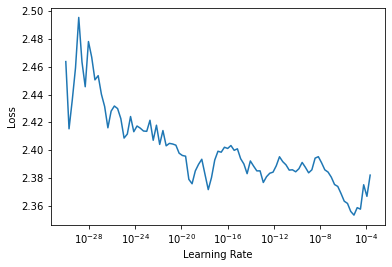

In [16]:
learner.lr_find(1e-30,1e-2)

In [17]:
learner.fit(10,5e-7)

epoch,train_loss,valid_loss,Accuracy,Curating_Of_Attention_Loss,time
0,1.955974,1.974213,0.233300,-0.000048,02:08


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


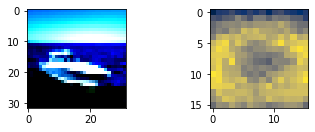

In [31]:
pred = learner.model(img.cuda())
pix_h = 8
pix_w = 8
plt.subplot(221)
plt.imshow(img[0].cpu().permute(1, 2, 0))
plt.subplot(222)
plt.imshow(pred[1][0,pix_h,pix_w,...].cpu().detach().numpy(),cmap='cividis', interpolation='nearest')#,vmax=threshold)